In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
fdata = sc.read_h5ad("./RNA/Multitime.annotation.h5")

In [9]:
fdata.obs["annotations"].value_counts()

annotations
Macrophages    827413
Others         618018
Malignant      580952
Fibroblast     316167
Unknown T      149975
DC             107797
MuscleCell      96487
Endothelial     81452
NK              50625
effector T      46949
memory T        18609
exhausted T      9633
stem-like T      5442
Epithelial        941
Name: count, dtype: int64

In [13]:
def extract_bin20(bin20_data, bin100_masked_data, replace_obs=None):

    try:
        bin100_mask = bin100_masked_data.obs["spatial_cov"].tolist()
        mask = [array in bin100_mask for array in bin20_data.obs["spatial_cov"]]
    except:
        bin20_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_data.obsm["spatial"]]
        bin100_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_masked_data.obsm["spatial"]]
        mask = [array in bin100_masked_data.obs["spatial_cov"].tolist() for array in tqdm(bin20_data.obs["spatial_cov"])]

    if replace_obs:
        for obj in replace_obs:
            spatial_to_obs = dict(zip(bin100_masked_data.obs["spatial_cov"], bin100_masked_data.obs[obj]))
            bin20_data.obs[obj] = bin20_data.obs["spatial_cov"].map(spatial_to_obs)
    return bin20_data[mask].copy()

def extract_bin100(bin100_data, bin20_masked_data):

    try:
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    except:
        bin100_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin100_data.obsm["spatial"]]
        bin20_masked_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100) * 100]) for array in bin20_masked_data.obsm["spatial"]]
        bin20_mask = bin20_masked_data.obs["spatial_cov"].unique().tolist()
        mask = [array in bin20_mask for array in bin100_data.obs["spatial_cov"]]
    return bin100_data[mask].copy()

def find_near(bin100, bin100_data, border=1, bin_size=100):
    #print("center of bin is ", bin100.obsm["spatial"][0])
    cmin = ((bin100.obsm["spatial"] // bin_size - border) * bin_size)[0]
    cmax = ((bin100.obsm["spatial"] // bin_size + border + 1) * bin_size)[0]
    #print("extracting bin from ", cmin, "to", cmax)
    mask = [cmin[0] <= array[0] <= cmax[0] and cmin[1] <= array[1] <= cmax[1] for array in bin100_data.obsm["spatial"]]
    return bin100_data[mask]

In [10]:
cluster_data = sc.read_h5ad("./RNA/Multitime.clustered.h5")

In [11]:
cluster_data

AnnData object with n_obs × n_vars = 118279 × 13177
    obs: 'marker', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster_cellcharter_givenk'
    var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
    uns: '_cellcharter', '_scvi_manager_uuid', '_scvi_uuid', 'cluster_cellcharter_givenk_colors', 'log1p', 'rank_genes_groups', 'spatial_neighbors'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Calculate the bin100 coordinate for bin20

In [28]:
marker = "1-1"
fdata_ = fdata[fdata.obs["marker"] == marker].copy()
cluster_data_ = cluster_data[cluster_data.obs["marker"] == marker].copy()
c_df = fdata_.obs[["spatial_cov", "annotations"]].groupby(["spatial_cov"]).value_counts().unstack().reindex()

In [36]:
c_df

annotations,NK,effector T,stem-like T,memory T,exhausted T,Unknown T,DC,Macrophages,Epithelial,Malignant,Endothelial,Fibroblast,MuscleCell,Others
spatial_cov,,,,,,,,,,,,,,
"(0, 0)",0,0,0,0,0,0,0,2,0,0,1,2,2,1
"(0, 100)",0,0,0,0,0,1,0,2,0,2,0,0,3,3
"(0, 200)",0,0,0,0,0,1,0,0,0,0,0,3,4,2
"(0, 300)",0,0,0,0,0,3,0,3,0,1,2,0,2,3
"(0, 400)",0,0,0,0,0,2,1,6,0,0,1,0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(14100, 9100)",0,0,1,0,0,0,0,6,0,2,0,4,1,1
"(14100, 9200)",0,0,0,0,0,0,0,4,0,2,0,4,1,4
"(14100, 9300)",0,1,0,0,0,1,0,2,0,1,0,4,0,1


In [82]:
cluster_data_[cluster_data_.obs["spatial_cov"] == (0, 400)].obs["cluster_cellcharter_givenk"]

5    9
Name: cluster_cellcharter_givenk, dtype: category
Categories (1, int64): [9]

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


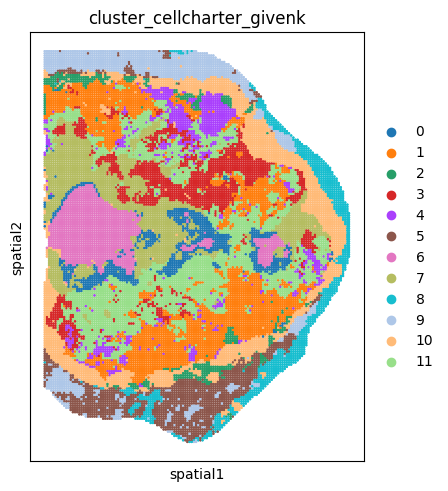

In [83]:
sq.pl.spatial_scatter(cluster_data_, color="cluster_cellcharter_givenk", shape=None, size=2, library_id="spatial")

In [58]:
c_df = pd.concat([c_df, cluster_data_.obs[["spatial_cov", "cluster_cellcharter_givenk"]].set_index("spatial_cov")], axis=1, join="inner")

In [81]:
c_df

,NK,effector T,stem-like T,memory T,exhausted T,Unknown T,DC,Macrophages,Epithelial,Malignant,Endothelial,Fibroblast,MuscleCell,Others,cluster_cellcharter_givenk
spatial_cov,,,,,,,,,,,,,,,
"(0, 0)",0,0,0,0,0,0,0,2,0,0,1,2,2,1,9
"(0, 100)",0,0,0,0,0,1,0,2,0,2,0,0,3,3,9
"(0, 200)",0,0,0,0,0,1,0,0,0,0,0,3,4,2,9
"(0, 300)",0,0,0,0,0,3,0,3,0,1,2,0,2,3,9
"(0, 400)",0,0,0,0,0,2,1,6,0,0,1,0,8,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(14100, 9100)",0,0,1,0,0,0,0,6,0,2,0,4,1,1,8
"(14100, 9200)",0,0,0,0,0,0,0,4,0,2,0,4,1,4,8
"(14100, 9300)",0,1,0,0,0,1,0,2,0,1,0,4,0,1,8


In [93]:
bin_counts = c_df.groupby("cluster_cellcharter_givenk").count()["Others"]
bin_counts

/tmp/ipykernel_71854/3524749975.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = c_df.groupby("cluster_cellcharter_givenk").count()["Others"]


cluster_cellcharter_givenk
0      880
1     3166
2      496
3     1697
4     1022
5     1488
6     1335
7     2208
8     1055
9     1461
10    2250
11    3479
Name: Others, dtype: int64

In [110]:
p_df = c_df.groupby("cluster_cellcharter_givenk").sum()
p_df = p_df.T / bin_counts
p_df = p_df.T / p_df.sum(axis=1)
p_df

/tmp/ipykernel_71854/880543467.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_df = c_df.groupby("cluster_cellcharter_givenk").sum()


,NK,effector T,stem-like T,memory T,exhausted T,Unknown T,DC,Macrophages,Epithelial,Malignant,Endothelial,Fibroblast,MuscleCell,Others
cluster_cellcharter_givenk,,,,,,,,,,,,,,
0,0.099524,0.089060,0.102081,0.086974,0.096857,0.095032,0.090664,0.079679,0.087829,0.119733,0.053921,0.047541,0.042076,0.044164
1,0.084674,0.098567,0.084274,0.094442,0.095068,0.090872,0.105448,0.103464,0.068354,0.079449,0.066443,0.061715,0.045333,0.037156
2,0.099939,0.058593,0.083798,0.082812,0.082342,0.107813,0.109095,0.079073,0.124660,0.056931,0.113550,0.101913,0.102367,0.188243
3,0.068376,0.150130,0.121672,0.135455,0.114056,0.068079,0.056266,0.102648,0.045545,0.094721,0.040241,0.060491,0.021963,0.009943
4,0.074386,0.147311,0.095769,0.122569,0.106856,0.065038,0.077197,0.097515,0.015125,0.094199,0.058966,0.057412,0.037724,0.021982
5,0.097101,0.045226,0.072985,0.044064,0.047138,0.083799,0.072597,0.063565,0.083107,0.049335,0.149318,0.122674,0.231219,0.185631
6,0.114224,0.076550,0.062268,0.058096,0.096434,0.107441,0.116124,0.072629,0.138947,0.114149,0.065602,0.058126,0.060368,0.069158
7,0.068559,0.072662,0.069224,0.080535,0.087258,0.077108,0.082912,0.080615,0.070008,0.127408,0.051270,0.047196,0.039820,0.047009
8,0.089757,0.036353,0.050835,0.033130,0.042920,0.085348,0.075063,0.058397,0.146520,0.044549,0.121850,0.146744,0.081949,0.228126


In [73]:
import seaborn as sns

Text(0.5, 1.0, '1-1 Cluster Celltyping Porportion, normalized by bin')

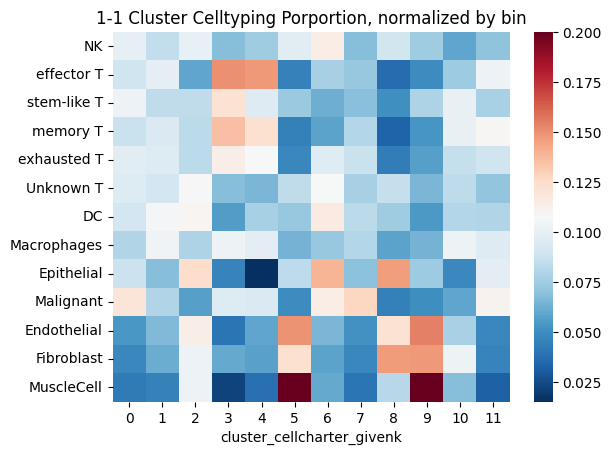

In [117]:
sns.heatmap(p_df.T.iloc[:-1], cmap="RdBu_r", vmax=0.2)
plt.title("1-1 Cluster Celltyping Porportion, normalized by bin")

/tmp/ipykernel_71854/3415189424.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = c_df.groupby("cluster_cellcharter_givenk").count()["Others"]
/tmp/ipykernel_71854/3415189424.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_df = c_df.groupby("cluster_cellcharter_givenk").sum()
/tmp/ipykernel_71854/3415189424.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = c_df.groupby("cluster_cellcha

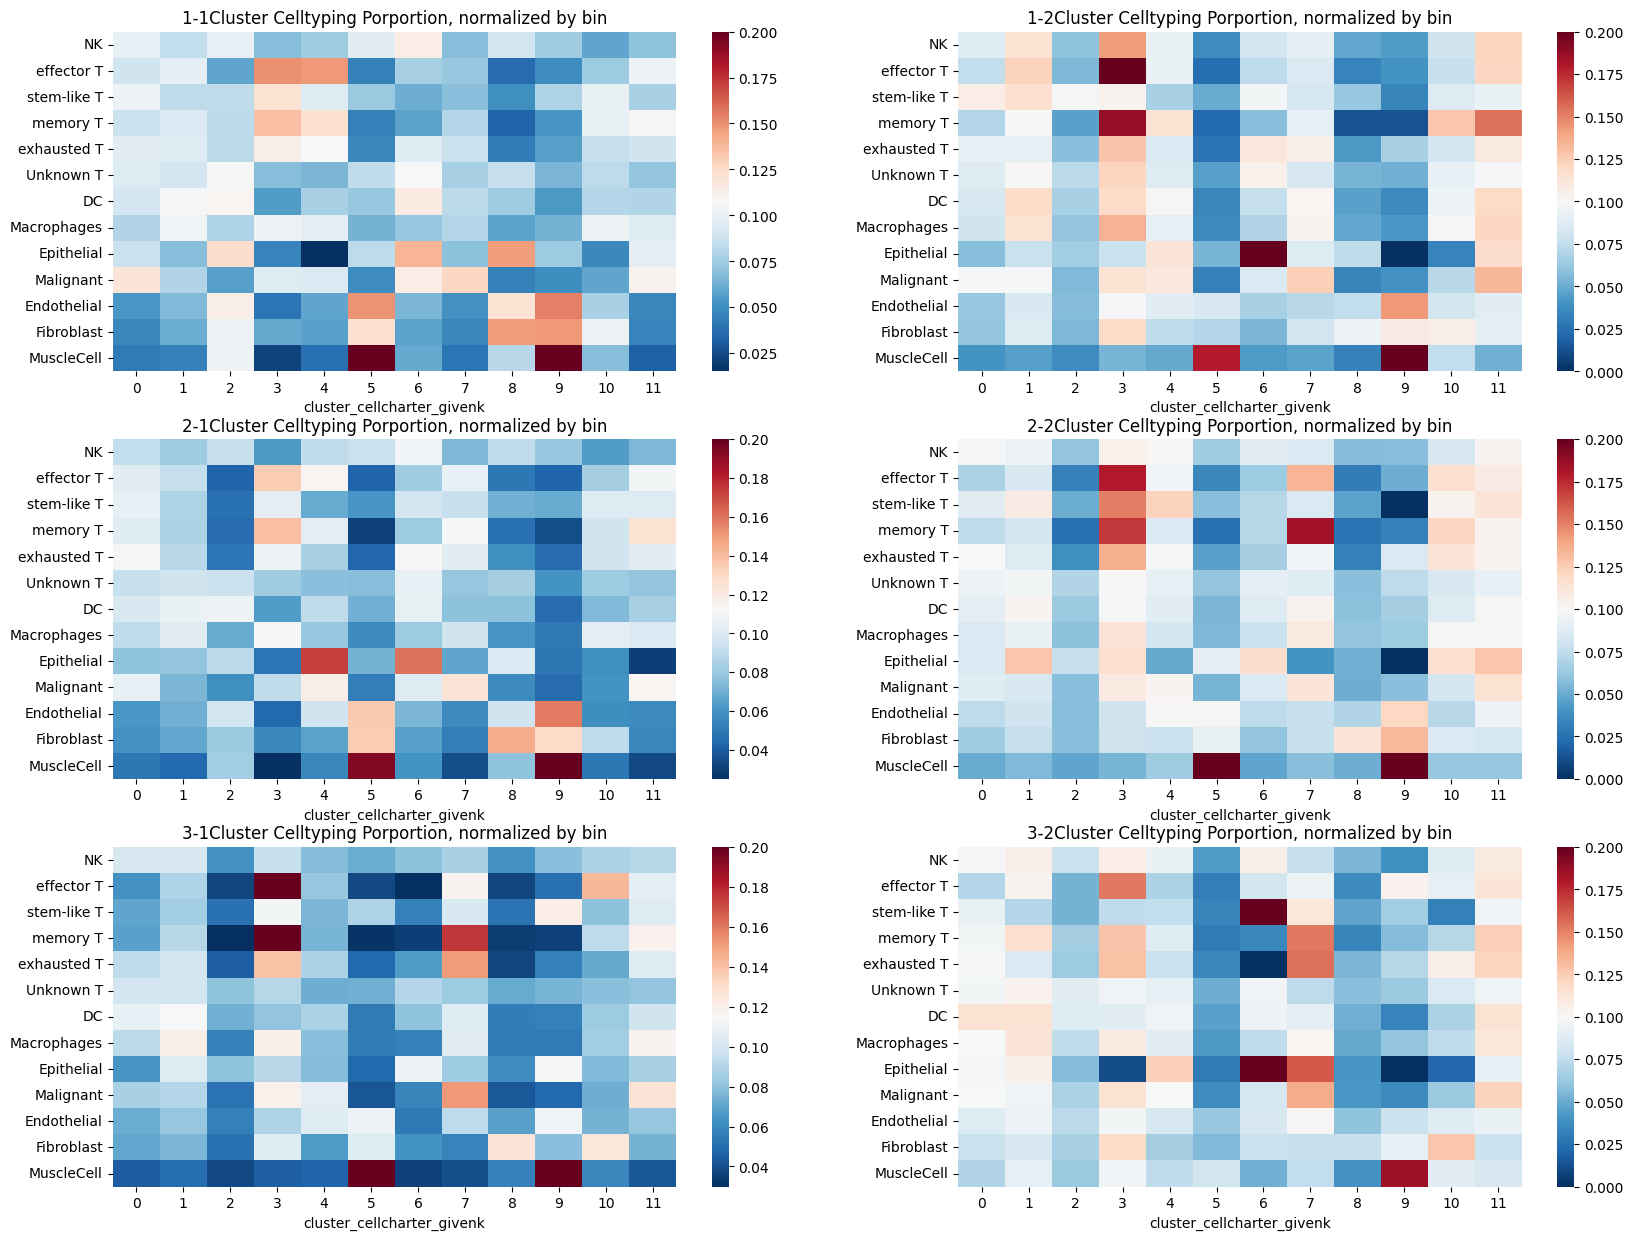

In [121]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
for idx, marker in enumerate(np.unique(fdata.obs["marker"])):
    fdata_ = fdata[fdata.obs["marker"] == marker].copy()
    cluster_data_ = cluster_data[cluster_data.obs["marker"] == marker].copy()
    c_df = fdata_.obs[["spatial_cov", "annotations"]].groupby(["spatial_cov"]).value_counts().unstack().reindex()
    c_df = pd.concat([c_df, cluster_data_.obs[["spatial_cov", "cluster_cellcharter_givenk"]].set_index("spatial_cov")], axis=1, join="inner")
    bin_counts = c_df.groupby("cluster_cellcharter_givenk").count()["Others"]

    p_df = c_df.groupby("cluster_cellcharter_givenk").sum()
    p_df = p_df.T / bin_counts
    p_df = p_df.T / p_df.sum(axis=1)
    sns.heatmap(p_df.T.iloc[:-1], cmap="RdBu_r", vmax=0.2, ax=ax[idx // 2, idx % 2])
    ax[idx // 2, idx % 2].set_title(marker + "Cluster Celltyping Porportion, normalized by bin")